# Project Assignment 3 : Amazon Review Classification System

## 0. Introduction

This project aims to develop a classification system for Amazon product reviews,During developing process, We used two methods;

**Binary Classification**  
For binary classification, the review dataset was divided into two categories: positive and negative, based on the star ratings. Reviews with 3-star ratings were excluded from the dataset, as they are considered neutral and do not clearly indicate either positive or negative.

**Multiclass Classification**
In this step, we aimed to predict the exact star ratings of the reviews. Therefore, 3-star reviews were retained in the dataset, as the task required distinguishing between all possible classes from 1 to 5 stars.



## 1. Importing and visualizing the data

In this section, we aimed to better understand the review dataset by visualizing the distribution of star ratings and examining the length of the review texts. These insights helped us identify potential class imbalances and guided how we prepared the data for classification.

### Install Required Libraries  
Before running the notebook, You can install all necessary libraries by running the following command by deleting "#":


In [100]:
# pip install pandas matplotlib seaborn scikit-learn


                                  Title  \
0                           Didn't work   
1  Worst nail product I have ever used.   
2                      Just didn't work   
3                                  Scum   
4                     Okay for cuticles   

                                             Content  Star  
0                         No change in nails at all.   1.0  
1  Garbage! Do not waste your $$$. My nails were ...   1.0  
2                            Nails are still brittle   1.0  
3                  Didn’t do any improvement at all.   1.0  
4  Helped cuticles, didn't do much for my nails. ...   1.0  
Data set size: (72500, 3)
Title      20
Content     7
Star        0
dtype: int64


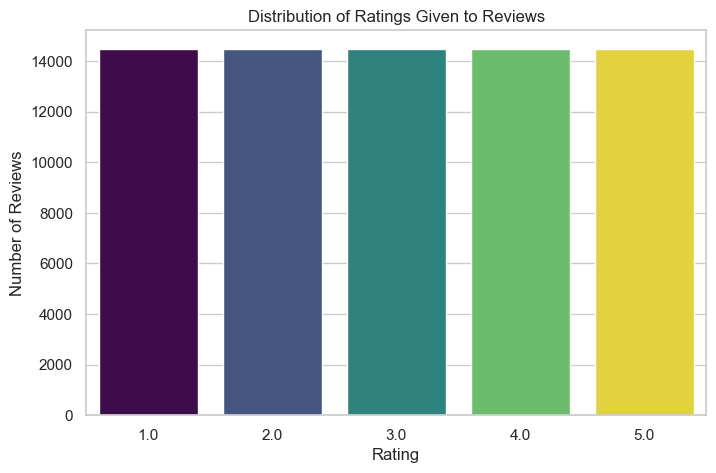

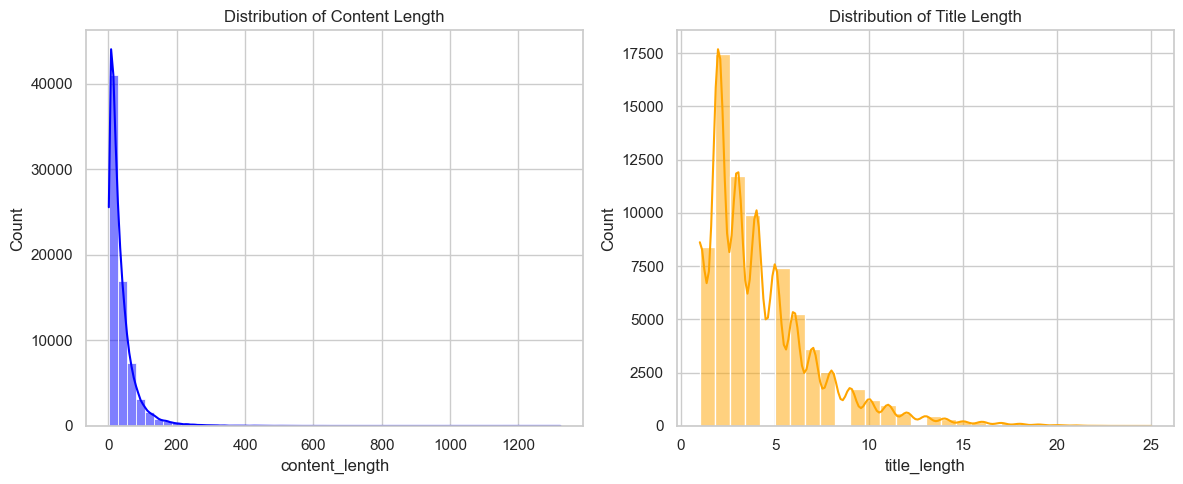

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from collections import defaultdict
import math

df = pd.read_csv("amazon_reviews.csv")

print(df.head())

print("Data set size:", df.shape)

print(df.isnull().sum())

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Star", hue="Star", palette="viridis", legend=False)
plt.title("Distribution of Ratings Given to Reviews")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

df["content_length"] = df["Content"].apply(lambda x: len(str(x).split()))
df["title_length"] = df["Title"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df["content_length"], bins=50, kde=True, color="blue")
plt.title("Distribution of Content Length")

plt.subplot(1,2,2)
sns.histplot(df["title_length"], bins=30, kde=True, color="orange")
plt.title("Distribution of Title Length")

plt.tight_layout()
plt.show()




## 2. Data Preprocessing and Splitting

In this step, we cleaned and preprocessed the text data by combining the title and content of each review, converting everything to lowercase, and removing punctuation. We created two separate datasets:

**Multiclass Classification Dataset:** We included all star ratings (1 to 5) and split the data into training and test sets using stratified sampling to preserve class distribution.

**Binary Classification Dataset:**   We excluded neutral (3-star) reviews and labeled the data as positive (stars 4 and 5) or negative (stars 1 and 2). This subset was also split into training and test sets using stratification.



In [102]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Title'] = df['Title'].fillna('')
df['Content'] = df['Content'].fillna('')
df['Processed_Text'] = (df['Title'] + ' ' + df['Content']).apply(preprocess)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    df['Processed_Text'],
    df['Star'],
    test_size=0.2,
    random_state=42,
    stratify=df['Star']
)

df_binary = df[df['Star'] != 3].copy()

df_binary['Label'] = df_binary['Star'].apply(lambda x: 1 if x >= 4 else 0)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    df_binary['Processed_Text'],
    df_binary['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df_binary['Label']
)


## 3. Naive Bayes Implementation


In this part, We developed a custom Naive Bayes classifier to perform text classification tasks using both unigram and n-gram representations. During the training phase, the algorithm tokenizes each input review into n-grams (e.g., unigrams, bigrams) and calculates the frequency of these n-grams separately for each class label. It also computes prior probabilities based on class distribution in the dataset.

For prediction, the model uses the learned word distributions and applies Laplace smoothing to handle unseen n-grams. The probabilities are computed in logarithmic space to prevent numerical underflow, and the class with the highest log-probability is selected as the predicted label. 

This implementation is capable of handling both binary (positive vs. negative sentiment) and multiclass (1 to 5 stars) classification problems.



In [103]:
def generate_ngrams(text, n=1):
    tokens = str(text).split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]


class NaiveBayesClassifier:
    def __init__(self, ngram_range=(1, 1)):
        self.ngram_range = ngram_range
        self.class_word_counts = defaultdict(lambda: defaultdict(float))
        self.class_totals = defaultdict(float)
        self.class_doc_counts = defaultdict(int)
        self.vocabulary = set()
        self.priors = {}

    def fit(self, X, y):
        for text, label in zip(X, y):
            self.class_doc_counts[label] += 1
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                ngrams = generate_ngrams(text, n)
                for ng in ngrams:
                    self.class_word_counts[label][ng] += 1
                    self.class_totals[label] += 1
                    self.vocabulary.add(ng)

        total_docs = sum(self.class_doc_counts.values())
        self.priors = {
            label: math.log(count / total_docs) for label, count in self.class_doc_counts.items()
        }

    def predict(self, X):
        predictions = []
        V = len(self.vocabulary)
        for text in X:
            class_scores = {}
            for label in self.class_word_counts:
                log_prob = self.priors[label]
                total_count = self.class_totals[label]
                word_counts = self.class_word_counts[label]
                for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                    ngrams = generate_ngrams(text, n)
                    for ng in ngrams:
                        count = word_counts.get(ng, 0)
                        log_prob += math.log((count + 1) / (total_count + V))
                class_scores[label] = log_prob
            predicted_label = max(class_scores, key=class_scores.get)
            predictions.append(predicted_label)
        return predictions



## 4. Custom Evaluation Metrics for Binary and Multiclass Classification


In this step, to assess the performance of our Naive Bayes classifier, we implemented custom evaluation functions instead of relying on built-in metrics from external libraries. These functions calculate the most important classification metrics: accuracy, precision, recall, and F1-score.

**For Binary Classification Dataset:**    We compute the number of true positives, true negatives, false positives, and false negatives. Based on these, we derive the precision, recall, and F1-score, which are critical for evaluating imbalanced datasets.

**For Multiclass Classification Dataset:**  We calculate the same metrics for each class label individually and report per-class results. Additionally, macro-averaged precision, recall, and F1-scores are computed to give an overall view of performance across all classes.

This approach provides a transparent and customizable evaluation framework, helping us deeply understand how well our model performs in different settings.




In [104]:
def compute_accuracy(y_true, y_pred):
    correct = sum(t == p for t, p in zip(y_true, y_pred))
    return correct / len(y_true)

def compute_binary_metrics(y_true, y_pred):
    TP = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    TN = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))
    FP = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    FN = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def compute_multiclass_metrics(y_true, y_pred, labels):
    metrics = {}
    
    for label in labels:
        TP = sum((yt == label and yp == label) for yt, yp in zip(y_true, y_pred))
        FP = sum((yt != label and yp == label) for yt, yp in zip(y_true, y_pred))
        FN = sum((yt == label and yp != label) for yt, yp in zip(y_true, y_pred))

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
        
        total_predictions = TP + FP + FN
        class_accuracy = TP / total_predictions if total_predictions > 0 else 0
        
        metrics[label] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": class_accuracy
        }

    macro_precision = sum(m["precision"] for m in metrics.values()) / len(labels)
    macro_recall = sum(m["recall"] for m in metrics.values()) / len(labels)
    macro_f1 = sum(m["f1"] for m in metrics.values()) / len(labels)

    accuracy = compute_accuracy(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "per_class": metrics
    }



## 5.Evaluation with Varying N-gram Sizes in Binary Classification


In this part, we tested how different n-gram sizes (unigrams, bigrams, and trigrams) affect the performance of the Naive Bayes classifier for binary classification (positive vs. negative reviews).

The best results came from using bigrams (n=2), which captured important word pairs and dependencies better than unigrams. Bigrams gave the best balance between accuracy, precision, and recall. Trigrams (n=3) had high recall but lower precision, leading to more false positives.

Overall, the model achieved around 90% accuracy, showing that it works well for classifying positive and negative reviews. This confirms that n-gram size plays an important role in model performance.

In [105]:
ngram_sizes = [1, 2, 3]

metrics_per_ngram = {}

for n in ngram_sizes:
    print(f"Evaluating for {n}-gram:")
    
    nb_model = NaiveBayesClassifier(ngram_range=(n, n))
    nb_model.fit(X_train_bin.tolist(), y_train_bin.tolist())
    
    y_pred = nb_model.predict(X_test_bin.tolist())
    
    metrics = compute_binary_metrics(y_test_bin.tolist(), y_pred)
    
    metrics_per_ngram[n] = metrics
    print_binary_metrics(metrics, n)


Evaluating for 1-gram:
Binary Classification Metrics (N-gram size = 1):
  Accuracy: 0.8719
  Precision: 0.8624
  Recall: 0.8850
  F1-Score: 0.8736
--------------------------------------------------
Evaluating for 2-gram:
Binary Classification Metrics (N-gram size = 2):
  Accuracy: 0.8969
  Precision: 0.8928
  Recall: 0.9021
  F1-Score: 0.8974
--------------------------------------------------
Evaluating for 3-gram:
Binary Classification Metrics (N-gram size = 3):
  Accuracy: 0.8491
  Precision: 0.8111
  Recall: 0.9100
  F1-Score: 0.8577
--------------------------------------------------



## 6.Evaluation with Varying N-gram Sizes in Multiclass Classification

In this part, we tested how different n-gram sizes (unigrams, bigrams, and trigrams) affect the performance of the Na,ve Bayes classifier for multiclass classification.

The best results came from using bigrams (n=2) and unigram (n=1). On the other hand,Trigrams (n=3) had lower performance.

Overall, the model achieved around 50% accuracy, showing that it works well for classifying reviews according to stars. 

When we look at classes 1, 2, 3, 4, and 5, we see that classes 1 (worst reviews) and 5 (best reviews) have higher accuracy. This is because extreme reviews (very good or very bad) are easier for the system to identify. However, the system has more difficulty with class 3 (neutral reviews) because these reviews are more balanced and harder to classify.

In [107]:
def print_multiclass_metrics(metrics, labels, ngram_size):
    print(f"Multiclass Classification Metrics (N-gram size = {ngram_size}):")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  Macro Recall: {metrics['macro_recall']:.4f}")
    print(f"  Macro F1-Score: {metrics['macro_f1']:.4f}")
    
    print("\nPer-Class Metrics:")
    for label in labels:
        class_metrics = metrics['per_class'][label]
        print(f"  Class {label}:")
        print(f"    Accuracy: {class_metrics['accuracy']:.4f}")
        print(f"    Precision: {class_metrics['precision']:.4f}")
        print(f"    Recall: {class_metrics['recall']:.4f}")
        print(f"    F1-Score: {class_metrics['f1']:.4f}")
    print("\n")
    
ngram_sizes = [1, 2, 3]

metrics_per_ngram_multi = {}

for n in ngram_sizes:
    print(f"Evaluating for {n}-gram:")
    
    nb_model = NaiveBayesClassifier(ngram_range=(n, n))
    nb_model.fit(X_train_multi.tolist(), y_train_multi.tolist())
    
    y_pred = nb_model.predict(X_test_multi.tolist())
    
    metrics = compute_multiclass_metrics(y_test_multi.tolist(), y_pred, labels_multi)
    
    metrics_per_ngram_multi[n] = metrics
    print_multiclass_metrics(metrics, labels_multi, n)


Evaluating for 1-gram:
Multiclass Classification Metrics (N-gram size = 1):
  Accuracy: 0.5019
  Macro Precision: 0.4957
  Macro Recall: 0.5019
  Macro F1-Score: 0.4982

Per-Class Metrics:
  Class 1.0:
    Accuracy: 0.4309
    Precision: 0.5732
    Recall: 0.6345
    F1-Score: 0.6023
  Class 2.0:
    Accuracy: 0.2243
    Precision: 0.3879
    Recall: 0.3472
    F1-Score: 0.3664
  Class 3.0:
    Accuracy: 0.2369
    Precision: 0.3871
    Recall: 0.3790
    F1-Score: 0.3830
  Class 4.0:
    Accuracy: 0.2892
    Precision: 0.4547
    Recall: 0.4428
    F1-Score: 0.4486
  Class 5.0:
    Accuracy: 0.5274
    Precision: 0.6757
    Recall: 0.7062
    F1-Score: 0.6906


Evaluating for 2-gram:
Multiclass Classification Metrics (N-gram size = 2):
  Accuracy: 0.5047
  Macro Precision: 0.5123
  Macro Recall: 0.5047
  Macro F1-Score: 0.5079

Per-Class Metrics:
  Class 1.0:
    Accuracy: 0.4144
    Precision: 0.5999
    Recall: 0.5728
    F1-Score: 0.5860
  Class 2.0:
    Accuracy: 0.2563
    Precis

## 7. Conclusion

In this project, We explored both binary and multiclass classification approaches, using different n-gram sizes (unigrams, bigrams, and trigrams) to evaluate the performance of the model.

For binary classification (positive vs. negative reviews), we observed that bigrams gave the best results in terms of accuracy and precision, capturing essential word pairs and their dependencies. Trigrams, while achieving high recall, resulted in lower precision, suggesting more false positives. The overall accuracy for binary classification was around 90%, demonstrating the model's effectiveness.

In multiclass classification, where we predicted ratings from 1 to 5, the model showed better accuracy for extreme ratings (1 and 5), as these were easier to distinguish. Neutral reviews (class 3) posed a challenge due to their balanced nature, leading to lower performance in this class.

Overall, the findings show that n-gram size plays a significant role in model performance, with careful tuning needed for optimal results. The model successfully captured the review sentiments, providing valuable insights for sentiment analysis tasks.




